# Heart Disease Prediction

## Importing Libraries

In [1]:
# Importing the libraries required
import os
import pickle

#third party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


## Create path

In [2]:
#path
CSV_PATH = os.path.join(os.getcwd(),'cardio_train.csv')
MODEL_PATH = os.path.join(os.getcwd(),'model.pkl')

## 1.0 Data Loading

In [3]:
df = pd.read_csv(CSV_PATH, sep=";")

## 1.1 Data Inspections

In [4]:
df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168.0,62.0,110,80,1.0,1,0,0.0,1,0
1,1,20228,1,156.0,85.0,140,90,3.0,1,0,0.0,1,1
2,2,18857,1,165.0,64.0,130,70,3.0,1,0,0.0,0,1
3,3,17623,2,169.0,82.0,150,100,1.0,1,0,0.0,1,1
4,4,17474,1,156.0,56.0,100,60,1.0,1,0,0.0,0,0
5,8,21914,1,151.0,67.0,120,80,2.0,2,0,0.0,0,0
6,9,22113,1,157.0,93.0,130,80,3.0,1,0,0.0,1,0
7,12,22584,2,178.0,95.0,130,90,3.0,3,0,0.0,1,1
8,13,17668,1,158.0,71.0,110,70,1.0,1,0,0.0,1,0
9,14,19834,1,164.0,68.0,110,60,1.0,1,0,0.0,0,0


In [5]:
## The age is given in days so we need to convert it into years

df['age'] = df['age'] // 365
# df["age"] = df["age"].apply(lambda x: round(x/365))

In [6]:
#check number of categories in each column
df.nunique()

id             70000
age               28
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

## 2.0 EDA

In [7]:
#get the keys of each col
df.columns  

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

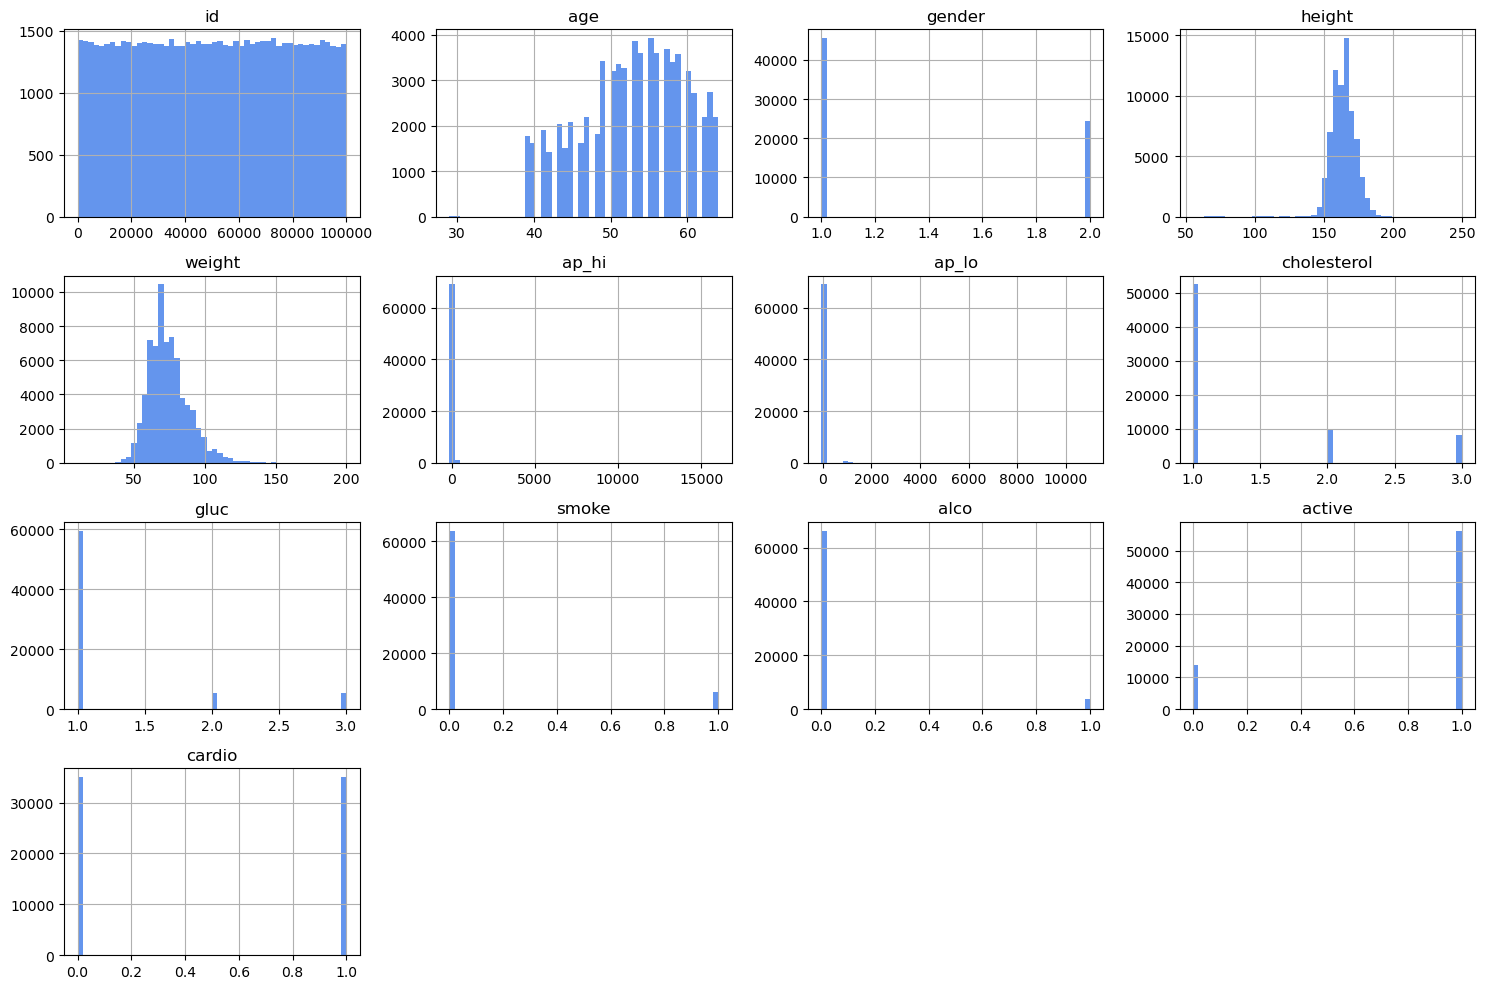

In [8]:
df.hist(figsize = (15,10), bins = 50, color = 'cornflowerblue')
plt.tight_layout()

Observation:
- From the histogram plot:
    - Continuous Variable : 'age', 'height', 'weight', 'ap_hi', 'ap_lo'
    - Categorical Variable: 'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'
- The target variable for dataset is cardio.

In [9]:
# separating the continuous and categorical columns (data)
df_cont = df[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]
df_cat = df.drop(['age', 'height', 'weight', 'id', 'ap_hi', 'ap_lo'], axis=1)

## 2.1 Setting Color Palette

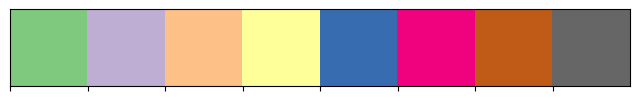

In [10]:
sns.palplot(sns.color_palette("Accent"))
sns.set_palette("Accent")
sns.set_style('whitegrid')

## 2.2 Histogram for all Continuous Variables

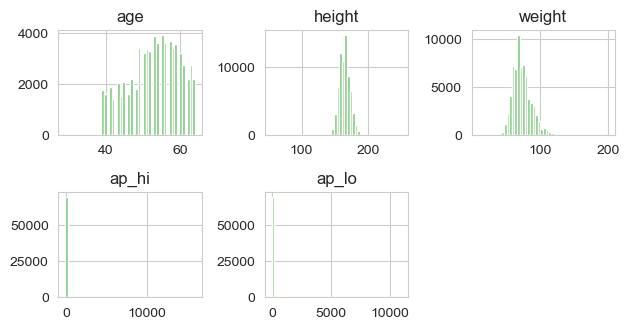

In [11]:
df_cont.hist(bins=50, layout=(3,3))
plt.tight_layout()

## 2.3 Countplot Vs Cardio for all Categorical Variables

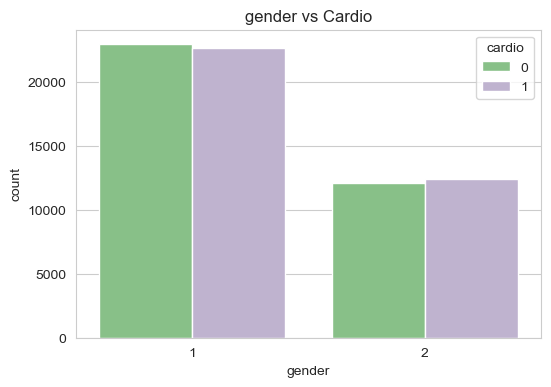

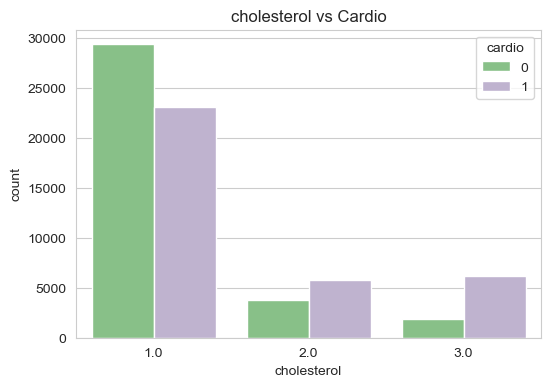

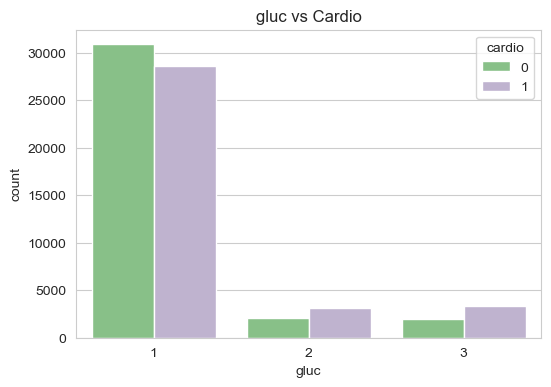

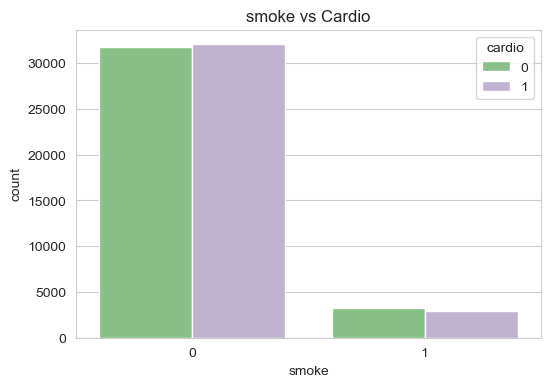

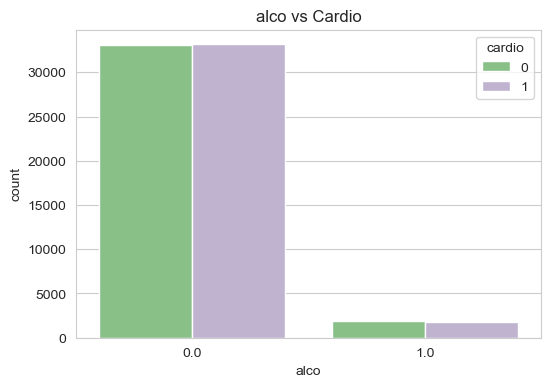

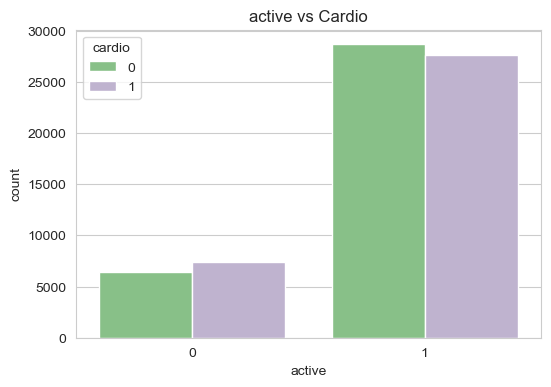

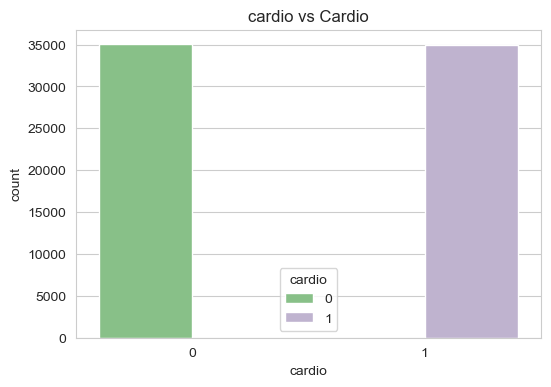

In [12]:
for column in df_cat.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x=column, data=df_cat, hue='cardio')

    plt.title(f'{column} vs Cardio')

## 2.4 Countplot for all Categorical columns

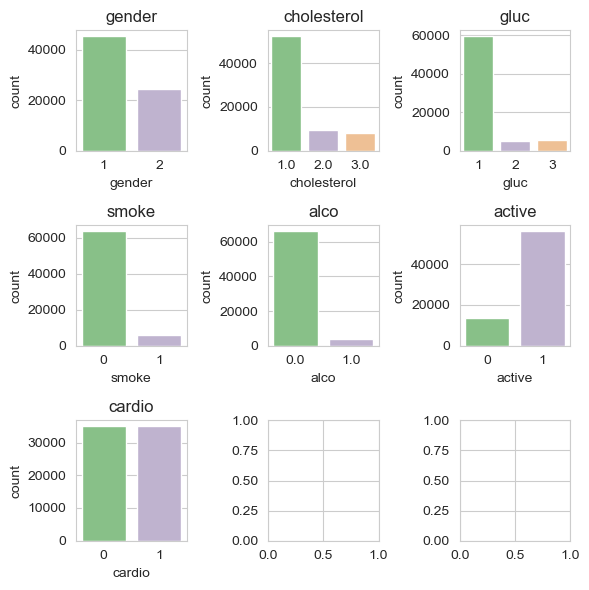

In [13]:
fig, axs = plt.subplots(3,3, figsize=(6,6))

axs = axs.ravel()

for i, column in enumerate(df_cat.columns):
    sns.countplot(x=column, data=df_cat, ax=axs[i])

    axs[i].set_title(f'{column}')
    #plt.legend(['No Disease', 'Disease'])
    
plt.tight_layout()

## 2.5 Correlation Matrix

<Axes: >

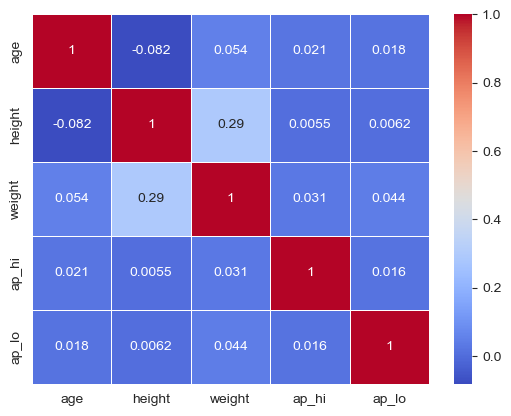

In [14]:
sns.heatmap(df_cont.corr(), annot=True, cmap='coolwarm', linewidths=0.5)

Observation:
- From the correlation matrix above, they are almost no correllation between all the continuous variables. 
- The highest correlation is between the 'height' and 'weight' variables with 0.29 correlation between them. 

## 3.0 Data Cleaning

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70003 entries, 0 to 70002
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70003 non-null  int64  
 1   age          70003 non-null  int64  
 2   gender       70003 non-null  int64  
 3   height       70001 non-null  float64
 4   weight       70002 non-null  float64
 5   ap_hi        70003 non-null  int64  
 6   ap_lo        70003 non-null  int64  
 7   cholesterol  70001 non-null  float64
 8   gluc         70003 non-null  int64  
 9   smoke        70003 non-null  int64  
 10  alco         70002 non-null  float64
 11  active       70003 non-null  int64  
 12  cardio       70003 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 6.9 MB


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70003.0,49970.283431,28852.529858,0.0,25002.5,50000.0,74887.5,99999.0
age,70003.0,52.840693,6.766672,29.0,48.0,53.0,58.0,64.0
gender,70003.0,1.349585,0.476842,1.0,1.0,1.0,2.0,2.0
height,70001.0,164.359023,8.210026,55.0,159.0,165.0,170.0,250.0
weight,70002.0,74.206013,14.396345,10.0,65.0,72.0,82.0,200.0
ap_hi,70003.0,128.817479,154.008162,-150.0,120.0,120.0,140.0,16020.0
ap_lo,70003.0,96.629987,188.468505,-70.0,80.0,80.0,90.0,11000.0
cholesterol,70001.0,1.366909,0.680255,1.0,1.0,1.0,2.0,3.0
gluc,70003.0,1.226476,0.572299,1.0,1.0,1.0,1.0,3.0
smoke,70003.0,0.088125,0.283478,0.0,0.0,0.0,0.0,1.0


## 3.1 Dealing with Outliers

### 3.1.1 Before removing the outliers

<Axes: >

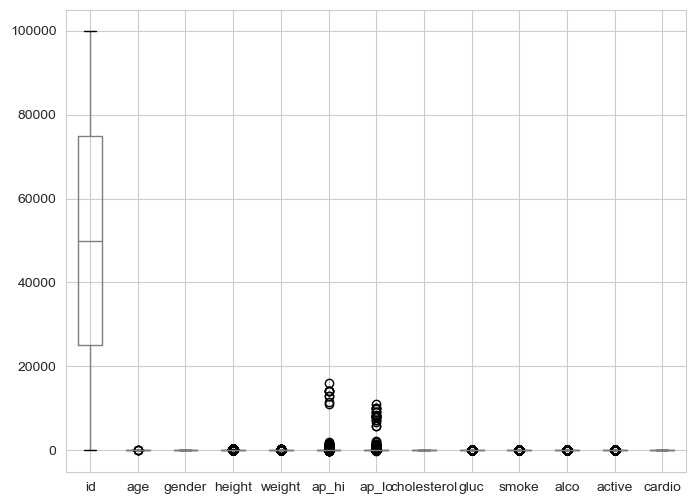

In [17]:
# plotting boxplot to check outliers
df.boxplot(figsize=(8,6))

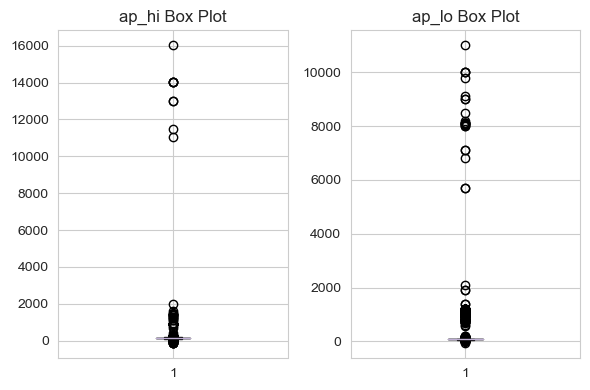

In [18]:
plt.figure(figsize=(6, 4))  # Adjust the figure size if needed

# Create a box plot for 'ap_hi'
plt.subplot(1, 2, 1)  # Creating a subplot with 1 row and 2 columns, this is the first plot
plt.boxplot(df['ap_hi'])
plt.title('ap_hi Box Plot')

# Create a box plot for 'ap_lo'
plt.subplot(1, 2, 2)  # Second plot in the same subplot
plt.boxplot(df['ap_lo'])
plt.title('ap_lo Box Plot')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()  # Display the plots

Observations:
- From the boxplot above, it can be seen that 'ap_li' and 'ap_lo' has some outliers inside the data.

### 3.1.2 After Removing the outliers

In [19]:
# Clipping the outliers within a reasonable range
# Remove the outliers that are above the blood pressure reading (Systolic/Diastolic) of 370/360 and 
# below 40/20 because these values cannot be considered as the blood pressure value of any human patient.
df = df[(df["ap_hi"] < 370) & (df["ap_lo"] < 360) & (df["ap_hi"] > 40) & (df["ap_lo"] > 20)]

<Axes: >

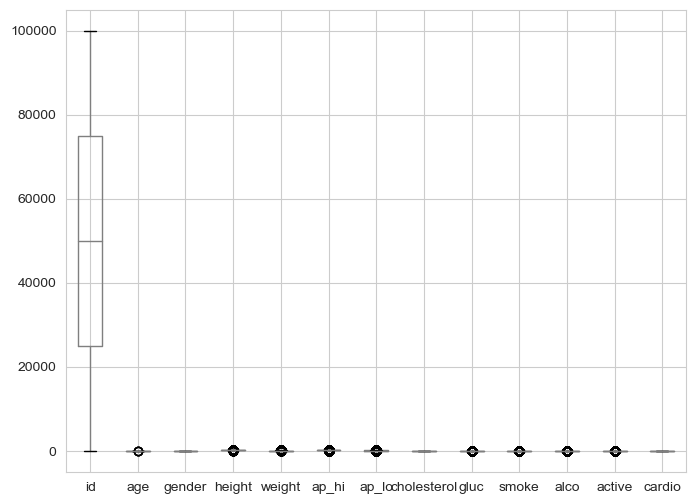

In [20]:
# plot boxplot again to see the difference.
df.boxplot(figsize=(8,6))

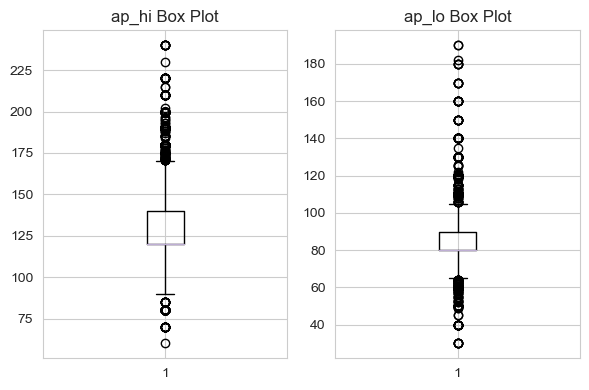

In [21]:
plt.figure(figsize=(6, 4))  # Adjust the figure size if needed

# Create a box plot for 'ap_hi'
plt.subplot(1, 2, 1)  # Creating a subplot with 1 row and 2 columns, this is the first plot
plt.boxplot(df['ap_hi'])
plt.title('ap_hi Box Plot')

# Create a box plot for 'ap_lo'
plt.subplot(1, 2, 2)  # Second plot in the same subplot
plt.boxplot(df['ap_lo'])
plt.title('ap_lo Box Plot')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()  # Display the plots

## 3.2 Dealing with Duplicate Data

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68784 entries, 0 to 70002
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           68784 non-null  int64  
 1   age          68784 non-null  int64  
 2   gender       68784 non-null  int64  
 3   height       68782 non-null  float64
 4   weight       68783 non-null  float64
 5   ap_hi        68784 non-null  int64  
 6   ap_lo        68784 non-null  int64  
 7   cholesterol  68782 non-null  float64
 8   gluc         68784 non-null  int64  
 9   smoke        68784 non-null  int64  
 10  alco         68783 non-null  float64
 11  active       68784 non-null  int64  
 12  cardio       68784 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 7.3 MB


In [23]:
df.duplicated().sum()

3

Observation: 
- They are 3 duplicated data inside the dataset.

In [24]:
# drop the duplicate data
df = df.drop_duplicates()

In [25]:
df.duplicated().sum()

0

## 3.3 Dealing with No Data

In [26]:
df.isnull().sum()

id             0
age            0
gender         0
height         2
weight         1
ap_hi          0
ap_lo          0
cholesterol    2
gluc           0
smoke          0
alco           1
active         0
cardio         0
dtype: int64

In [27]:
df.isna().any()

id             False
age            False
gender         False
height          True
weight          True
ap_hi          False
ap_lo          False
cholesterol     True
gluc           False
smoke          False
alco            True
active         False
cardio         False
dtype: bool

In [28]:
df = df.dropna()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68775 entries, 0 to 70002
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           68775 non-null  int64  
 1   age          68775 non-null  int64  
 2   gender       68775 non-null  int64  
 3   height       68775 non-null  float64
 4   weight       68775 non-null  float64
 5   ap_hi        68775 non-null  int64  
 6   ap_lo        68775 non-null  int64  
 7   cholesterol  68775 non-null  float64
 8   gluc         68775 non-null  int64  
 9   smoke        68775 non-null  int64  
 10  alco         68775 non-null  float64
 11  active       68775 non-null  int64  
 12  cardio       68775 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 7.3 MB


## 4.0 Feature Engineering

## 4.1 Binning/Bucketing

Text(0.5, 1.0, 'BMI ranges vs Cardio')

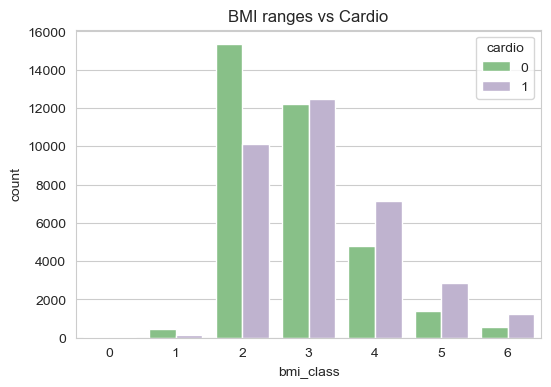

In [30]:
# for bmi
df["bmi"] = df["weight"] *10000 / ((df["height"])**2)

bmi_ranges = [
    (df["bmi"] <= 15),                                  # 0 - Anorexic
    (df["bmi"] > 15) & (df["bmi"] <= 18.5),             # 1 - Underweight
    (df["bmi"] > 18.5) & (df["bmi"] <= 25),             # 2 - Normal weight
    (df["bmi"] > 25) & (df["bmi"] <= 30),               # 3 - Overweight
    (df["bmi"] > 30) & (df["bmi"] <= 35),               # 4 - Obesity Class I
    (df["bmi"] > 35) & (df["bmi"] <= 40),               # 5 - Obesity Class II
    (df["bmi"] > 40)                                    # 6 - Obesity Class III 
]

classes = [0, 1, 2, 3, 4, 5, 6]

df["bmi_class"] = np.select(bmi_ranges, classes)

#plot the countplot for bmi_ranges
plt.figure(figsize=(6,4))
sns.countplot(x='bmi_class',data=df,hue='cardio')
plt.title('BMI ranges vs Cardio')

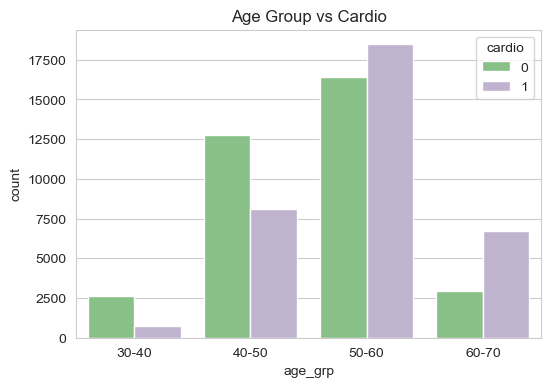

In [31]:
# Creating age groups
df['age_grp'] = pd.cut(df['age'], 
                       bins=[30, 40, 50, 60, 70],
                       labels=['30-40', '40-50', '50-60', '60-70'])

# Plotting the count plot for age_grp
plt.figure(figsize=(6, 4))
sns.countplot(x='age_grp', data=df, hue='cardio')
plt.title('Age Group vs Cardio')

# Mapping the age_grp to numerical values
age_grp_map = {'30-40': 1, '40-50': 2, '50-60': 3, '60-70': 4}

# Handling NaN values before mapping
df['age_grp'] = df['age_grp'].map(age_grp_map)
df['age_grp'] = df['age_grp'].dropna  # drop NaN values

In [32]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi',
       'bmi_class', 'age_grp'],
      dtype='object')

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,68775.0,49973.466216,28845.040925,0.000000,24997.500000,50012.000000,74864.500000,99999.000000
age,68775.0,52.828382,6.769254,29.000000,48.000000,53.000000,58.000000,64.000000
gender,68775.0,1.348731,0.476572,1.000000,1.000000,1.000000,2.000000,2.000000
height,68775.0,164.361876,8.184889,55.000000,159.000000,165.000000,170.000000,250.000000
weight,68775.0,74.122814,14.331381,11.000000,65.000000,72.000000,82.000000,200.000000
ap_hi,68775.0,126.614846,16.763735,60.000000,120.000000,120.000000,140.000000,240.000000
ap_lo,68775.0,81.377535,9.688418,30.000000,80.000000,80.000000,90.000000,190.000000
cholesterol,68775.0,1.364755,0.679001,1.000000,1.000000,1.000000,2.000000,3.000000
gluc,68775.0,1.226012,0.571989,1.000000,1.000000,1.000000,1.000000,3.000000
smoke,68775.0,0.088012,0.283314,0.000000,0.000000,0.000000,0.000000,1.000000


## 4.2 K-means Clustering

In [34]:
df_cont.isnull().sum()

age       0
height    2
weight    1
ap_hi     0
ap_lo     0
dtype: int64

In [35]:
df_cont = df_cont.dropna()

c:\Users\fahmi\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\fahmi\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\fahmi\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\fahmi\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

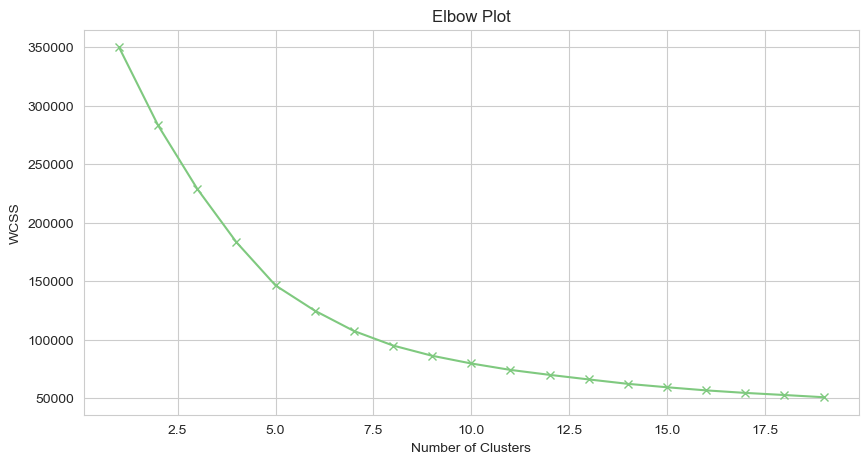

In [36]:
#using kmeans for only continuous variables
scaler = StandardScaler().fit(df_cont)
df_con_scaled = scaler.transform(df_cont)

wcss = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, random_state=13)
    kmeans.fit(df_con_scaled)
    wcss.append(kmeans.inertia_)

#plot
plt.figure(figsize=(10,5))
plt.plot(range(1,20), wcss, marker='x')
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## 5.0 Data Preprocessing

## 5.1 Encoding Categorical Variables - LabelEncoding()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68775 entries, 0 to 70002
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           68775 non-null  int64  
 1   age          68775 non-null  int64  
 2   gender       68775 non-null  int64  
 3   height       68775 non-null  float64
 4   weight       68775 non-null  float64
 5   ap_hi        68775 non-null  int64  
 6   ap_lo        68775 non-null  int64  
 7   cholesterol  68775 non-null  float64
 8   gluc         68775 non-null  int64  
 9   smoke        68775 non-null  int64  
 10  alco         68775 non-null  float64
 11  active       68775 non-null  int64  
 12  cardio       68775 non-null  int64  
 13  bmi          68775 non-null  float64
 14  bmi_class    68775 non-null  int32  
 15  age_grp      68775 non-null  object 
dtypes: float64(5), int32(1), int64(9), object(1)
memory usage: 8.7+ MB


In [38]:
# #Mapping the categorical variables to numerical values using LabelEncoder
# le = LabelEncoder()
# df['bmi_class'] = le.fit_transform(df['bmi_class'])

In [39]:
#Mapping the categorical variables to numerical values using LabelEncoder
le = LabelEncoder()
df['age_grp'] = le.fit_transform(df['age_grp'])

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68775 entries, 0 to 70002
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           68775 non-null  int64  
 1   age          68775 non-null  int64  
 2   gender       68775 non-null  int64  
 3   height       68775 non-null  float64
 4   weight       68775 non-null  float64
 5   ap_hi        68775 non-null  int64  
 6   ap_lo        68775 non-null  int64  
 7   cholesterol  68775 non-null  float64
 8   gluc         68775 non-null  int64  
 9   smoke        68775 non-null  int64  
 10  alco         68775 non-null  float64
 11  active       68775 non-null  int64  
 12  cardio       68775 non-null  int64  
 13  bmi          68775 non-null  float64
 14  bmi_class    68775 non-null  int32  
 15  age_grp      68775 non-null  int32  
dtypes: float64(5), int32(2), int64(9)
memory usage: 8.4 MB


## 5.2 Train Test Split

In [41]:
X= df.drop(['cardio','id'],axis=1)
y= df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=41,stratify=y)

## 6.0 ML Pipeline

In [42]:
# creating a pipeline dict
pipelines = [
    ("SS+LR", Pipeline([("SS",StandardScaler()),("LR",LogisticRegression(max_iter=1000))])),
    ("MM+LR", Pipeline([("MM",MinMaxScaler()),("LR",LogisticRegression(max_iter=1000))])),
    ("SS+RF", Pipeline([("SS",StandardScaler()),("RF",RandomForestClassifier())])),
    ("MM+RF", Pipeline([("MM",MinMaxScaler()),("RF",RandomForestClassifier())])),
    ("SS+SVC", Pipeline([("SS",StandardScaler()),("SVC",SVC())])),
    ("MM+SVC", Pipeline([("MM",MinMaxScaler()),("SVC",SVC())])),
    ("SS+KNN", Pipeline([("SS",StandardScaler()),("KNN",KNeighborsClassifier())])),
    ("MM+KNN", Pipeline([("MM",MinMaxScaler()),("KNN",KNeighborsClassifier())])),
]

In [43]:
#training all the pipelines

result_dict={}
best_score =0.0
best_pipe=''

for name,pipe in pipelines:
    print(f'Training {name}..')
    pipe.fit(X_train,y_train)
    
    y_pred = pipe.predict(X_test)
    
    result_dict[name]=[accuracy_score(y_test,y_pred),
                       precision_score(y_test,y_pred),
                       recall_score(y_test,y_pred),
                       f1_score(y_test,y_pred,average='weighted'),
                       roc_auc_score(y_test,y_pred)]
    if pipe.score(X_test,y_test)>best_score:
        best_score = pipe.score(X_test,y_test)
        best_pipe = name

print(f'The best model is {best_pipe} with the accuracy score of {best_score}')

Training SS+LR..
Training MM+LR..
Training SS+RF..
Training MM+RF..
Training SS+SVC..
Training MM+SVC..
Training SS+KNN..
Training MM+KNN..
The best model is SS+SVC with the accuracy score of 0.7348907090583047


## 7.0 Model Comparison and Evaluation

In [44]:
result_df = pd.DataFrame(result_dict, index=['Accuracy','Precision','Recall','F1 Score','ROC AUC Score']).T

In [45]:
result_df.sort_values(by='Accuracy',ascending=False).style.background_gradient(cmap='Purples')

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
SS+SVC,0.734891,0.759409,0.679691,0.734032,0.734337
MM+SVC,0.731934,0.752672,0.682726,0.731240,0.731441
SS+LR,0.728881,0.750706,0.677047,0.728105,0.728361
MM+LR,0.728832,0.750461,0.677340,0.728067,0.728316
SS+RF,0.707265,0.706045,0.699961,0.707247,0.707192
MM+RF,0.707071,0.705078,0.701626,0.707062,0.707017
SS+KNN,0.693743,0.693009,0.684391,0.693712,0.693649
MM+KNN,0.692725,0.692598,0.681747,0.692683,0.692615


## 8.0 Hyperparameter Tuning

In [46]:
pipeline_ss_svc = Pipeline([("SS",StandardScaler()),("SVC",SVC())])

In [47]:
pipeline_ss_svc.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'SS', 'SVC', 'SS__copy', 'SS__with_mean', 'SS__with_std', 'SVC__C', 'SVC__break_ties', 'SVC__cache_size', 'SVC__class_weight', 'SVC__coef0', 'SVC__decision_function_shape', 'SVC__degree', 'SVC__gamma', 'SVC__kernel', 'SVC__max_iter', 'SVC__probability', 'SVC__random_state', 'SVC__shrinking', 'SVC__tol', 'SVC__verbose'])

In [48]:
# Define the hyperparameter distributions
random_cv = {
    'SVC__C': [0.1, 1, 10],
    'SVC__kernel': ['rbf'],
    'SVC__gamma': ['auto'],
}

In [50]:
random_search = GridSearchCV(
    estimator=pipeline_ss_svc, 
    param_grid= random_cv, 
    cv=5, 
    verbose=2, 
    n_jobs=4
)

In [51]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('SS', StandardScaler()),
                                       ('SVC', SVC())]),
             n_jobs=4,
             param_grid={'SVC__C': [0.1, 1, 10], 'SVC__gamma': ['auto'],
                         'SVC__kernel': ['rbf']},
             verbose=2)

In [52]:
#print the best parameters
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")
print(f"Grid Search Best Score: {random_search.score(X_test, y_test)}")

Best Parameters: {'SVC__C': 1, 'SVC__gamma': 'auto', 'SVC__kernel': 'rbf'}
Best Score: 0.7312533548880327
Grid Search Best Score: 0.7350361072069016


## 9.0 Model Evaluation

Classification Report: 
              precision    recall  f1-score   support

           0       0.72      0.79      0.75     10421
           1       0.76      0.68      0.72     10212

    accuracy                           0.74     20633
   macro avg       0.74      0.73      0.73     20633
weighted avg       0.74      0.74      0.73     20633



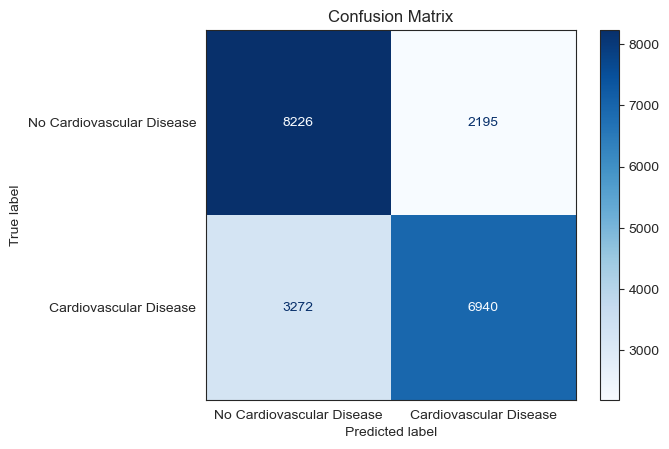

In [54]:
y_pred = random_search.predict(X_test)

labels = ["No Cardiovascular Disease", "Cardiovascular Disease"]

# print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

#displaying confusion matrix using ConfusionMatrixDisplay
#remove the whitegrid
sns.set_style('white')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.rcParams['figure.figsize'] = (5, 5)
plt.show()

Observation:
1. Classification Report
    - Precision: Out of all the patients that the model predicted have Cardiovascular Disease, only 76% actually did.
    - Recall: Out of all the patients that have Cardiovascular Disease, the model only predicted this outcome correctly for 68% of those patients.
    - F1 score: Since this value is near to 1, it tells us that the model does a good job of predicting whether or not the patients have Cardiovascular Disease.
    - Support: These value tell us how many patients belonged to each class in the test dataset. We can see that among the patients in the test dataset, 10421 have no Cardiovascular Disease and 10212 have Cardiovascular Disease.
2. Confusion Matrix
    - True Positive: Out of 10212 patients that have been diagnosed has Cardiovascular Disease, 6940 patients truly has Cardiovascular Disease.
    - True Negative: Out of 10421 patients that have been diagnosed do not has Cardiovascular Disease, 8226 patients truly has no Cardiovascular Disease.
    - False Positive: Out of 10421 patients that have been diagnosed do not has Cardiovascular Disease, 2195 have been suspected has Cardiovascular Disease.
    - False Negative: Out of 10212 patients that have been diagnosed has Cardiovascular Disease, 3272 have been suspected do not have Cardiovascular Disease.

## 10.0 Model Saving

In [55]:
#saving the best model from Random SearchCV

with open (MODEL_PATH, 'wb') as file:  #wb = write binary
    pickle.dump(random_search.best_estimator_, file)